<a href="https://colab.research.google.com/github/aoloo-r/Breast-Cancer-Prognosis-Prediction/blob/main/Clinical_Data_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [48]:
import torch
import re
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Mount dataset folder from Google Drive to environment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


# Data Preprocessing
**data encoding is currently incomplete**

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

def encode_clinical_data(df):
    """
    Encodes clinical data with the understanding that real data starts at row 4.
    Rows 1-3 contain header/metadata information.

    Parameters:
    -----------
    df : pandas.DataFrame
        The clinical dataframe to encode

    Returns:
    --------
    pandas.DataFrame
        The encoded dataframe with all columns properly processed
    """
    # Create a copy to avoid modifying the original
    encoded_df = df.copy()

    # First, check if we need to handle the header rows
    # If the dataframe has already been loaded with headers processed
    # (i.e., headers are in column names), we don't need this step
    if encoded_df.shape[0] >= 4:
        print("Checking if data starts at row 4...")
        # Sample some values to see if first 3 rows appear to be headers
        sample_col = encoded_df.columns[0]
        first_rows = encoded_df.loc[0:3, sample_col].tolist()
        print(f"First rows of sample column: {first_rows}")

        # If first rows look like headers, remove them
        if any(isinstance(val, str) and '=' in str(val) for val in first_rows):
            print("First rows appear to contain metadata. Removing rows 0-3...")
            encoded_df = encoded_df.iloc[3:].reset_index(drop=True)
            print(f"Dataframe shape after removing header rows: {encoded_df.shape}")

    # Identify the target column
    target_col = None
    for col in encoded_df.columns:
        if "Recurrence event" in col:
            target_col = col
            target_values = encoded_df[target_col].copy()
            print(f"Identified target column: {target_col}")
            break

    # Process each column individually
    all_columns = encoded_df.columns.tolist()
    print(f"Processing {len(all_columns)} total columns")

    for col in all_columns:
        # Skip target column for now
        if col == target_col:
            continue

        print(f"Processing column: {col}")

        try:
            # Check column data type
            if encoded_df[col].dtype == 'object':
                # Categorical column
                print(f"  Processing as categorical")

                # Fill missing values
                encoded_df[col] = encoded_df[col].fillna("MISSING")

                # Convert to string
                encoded_df[col] = encoded_df[col].astype(str)

                # Apply label encoding
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(encoded_df[col])
                print(f"  Encoded {len(le.classes_)} unique values")

            else:
                # Numeric column
                print(f"  Processing as numeric")

                # Handle missing values
                if encoded_df[col].isna().any():
                    if encoded_df[col].isna().all():
                        encoded_df[col] = 0
                        print(f"  All values missing, filled with 0")
                    else:
                        median = encoded_df[col].median()
                        encoded_df[col] = encoded_df[col].fillna(median)
                        print(f"  Filled missing values with median: {median}")

                # Standardize if there's variance
                if encoded_df[col].std() > 0:
                    mean_val = encoded_df[col].mean()
                    std_val = encoded_df[col].std()
                    encoded_df[col] = (encoded_df[col] - mean_val) / std_val
                    print(f"  Standardized numeric column")

        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")

            # Try alternative approach
            try:
                print(f"  Trying alternative encoding approach")

                # Force to string and encode
                encoded_df[col] = encoded_df[col].fillna("MISSING")
                encoded_df[col] = encoded_df[col].astype(str)
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(encoded_df[col])
                print(f"  Alternative encoding successful")

            except Exception as e2:
                print(f"  Alternative approach failed: {str(e2)}")
                print(f"  Setting column to 0")
                encoded_df[col] = 0

    # Restore target column
    if target_col and 'target_values' in locals():
        encoded_df[target_col] = target_values
        print(f"Restored target column: {target_col}")

    # Final check for any NaN values
    if encoded_df.isna().any().any():
        nan_cols = encoded_df.columns[encoded_df.isna().any()].tolist()
        print(f"Filling NaN values in {len(nan_cols)} columns")
        encoded_df = encoded_df.fillna(0)

    print(f"Final encoded dataframe shape: {encoded_df.shape}")
    return encoded_df

In [62]:
# Load the data
file_path = 'Clinical_and_Other_Features.xlsx'
clinical_df = pd.read_excel(file_path, header=[1, 2])

# Function to merge multi-index headers to single index headers
def merge_headers(col_tuple):
    # Unpack the tuple: first-level and second-level names
    first, second = col_tuple

    # If newline characters exist, remove and replace with space
    if isinstance(first, str):
        first = first.replace('\n', ' ').strip()
    if isinstance(second, str):
        second = second.replace('\n', ' ').strip()

    # If blank second-headers exist, return first-header only
    if not second or 'Unnamed' in second:
        return first
    # Otherwise, return merged header
    else:
        return f"{first} - {second}"

# Preprocess the column headers
# Merge multi-index headers for all columns
new_columns = [merge_headers(col) for col in clinical_df.columns]
clinical_df.columns = new_columns

# Print column info
print(f"Total columns: {len(clinical_df.columns)}")
print(f"Sample size: {len(clinical_df)}")

Total columns: 98
Sample size: 922


In [76]:
# target variable
target_col = "Recurrence event(s) - {0 = no, 1 = yes}"
if target_col not in clinical_df.columns:
    # Find the correct column name by looking for a substring match
    matching_cols = [col for col in clinical_df.columns if "Recurrence event" in col]
    if matching_cols:
        target_col = matching_cols[0]
        print(f"Found target column: {target_col}")
    else:
        raise ValueError("Target column not found! Please check the column names.")
# Check target variable for NaNs
if np.isnan(y_test).any():
    print("Warning: NaN values found in y_test! Using most common value...")
    most_common = int(np.round(np.nanmean(y_test)))
    y_test = np.nan_to_num(y_test, nan=most_common)

# Encode the data
encoded_df = encode_clinical_data(clinical_df)
print(f"Encoded data shape: {encoded_df.shape}")


Checking if data starts at row 4...
First rows of sample column: ['Breast_MRI_001', 'Breast_MRI_002', 'Breast_MRI_003', 'Breast_MRI_004']
Identified target column: Recurrence event(s) - {0 = no, 1 = yes}
Processing 98 total columns
Processing column: Patient ID
  Processing as categorical
  Encoded 922 unique values
Processing column: Days to MRI (From the Date of Diagnosis)
  Processing as numeric
  Standardized numeric column
Processing column: Manufacturer - GE MEDICAL SYSTEMS=0, MPTronic software=1, SIEMENS=2
  Processing as numeric
  Standardized numeric column
Processing column: Manufacturer Model Name - Avanto=0, Optima MR450w=1, SIGNA EXCITE=2, SIGNA HDx=3, Signa HDxt=4, Skyra=5, Trio=6, TrioTim=7
  Processing as numeric
  Standardized numeric column
Processing column: Scan Options - FAST_GEMS\SAT_GEMS\ACC_GEMS\PFP\FS=0,FAST_GEMS\SAT_GEMS\MP_GEMS\ACC_GEMS\PFP\FS=1,FAST_GEMS\SAT_GEMS\MP_GEMS\PFP\FS=2,FAST_GEMS\SAT_GEMS\PFP\FS=3,FS=4,PFP\FS=5,PFP\SFS=6,SAT_GEMS\PFP\FS=7,SFS=8
  P

In [77]:
# Split the data into features and target
X = encoded_df.drop(columns=[target_col]) if target_col in encoded_df.columns else encoded_df
y = encoded_df[target_col] if target_col in encoded_df.columns else None

# Print info about target distribution
if y is not None:
    print(f"Target distribution:\n{y.value_counts()}")
else:
    print("Warning: Target column not found in encoded dataframe!")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

# Reshape data for RNN (sequence data)
# RNNs expect input of shape (batch_size, time_steps, features)
X_train_seq = np.expand_dims(X_train.values, axis=1)  # shape: (samples, 1, features)
X_val_seq = np.expand_dims(X_val.values, axis=1)
X_test_seq = np.expand_dims(X_test.values, axis=1)


# Check for NaN values using np.isnan for NumPy arrays
if np.isnan(X_test_seq).any():
    print("Warning: NaN values found in test data! Filling with 0...")
    X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)

X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)

print("Sequence shapes:")
print("X_train_seq:", X_train_seq.shape)
print("X_val_seq:", X_val_seq.shape)
print("X_test_seq:", X_test_seq.shape)

Target distribution:
Recurrence event(s) - {0 = no, 1 = yes}
0.0    835
1.0     87
Name: count, dtype: int64
Training set size: (645, 97) (645,)
Validation set size: (138, 97) (138,)
Test set size: (139, 97) (139,)
Sequence shapes:
X_train_seq: (645, 1, 97)
X_val_seq: (138, 1, 97)
X_test_seq: (139, 1, 97)


# RNN Model Training Pipeline
**must complete encoding before training**

In [78]:
from tensorflow.keras.layers import Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

def build_advanced_rnn_model(input_shape, rnn_type='LSTM', units=64,
                            bidirectional=True, attention=False,
                            dropout_rate=0.3, l1_reg=0.0001, l2_reg=0.0001):
    """
    Build an advanced RNN model with various architectural improvements:
    - Bidirectional RNN layers
    - Batch normalization
    - Regularization (dropout, L1, L2)

    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (time_steps, features)
    rnn_type : str, default='LSTM'
        Type of RNN layer ('LSTM' or 'GRU')
    units : int, default=64
        Number of RNN units
    bidirectional : bool, default=True
        Whether to use bidirectional RNNs
    attention : bool, default=False
        Whether to add an attention mechanism (simplified)
    dropout_rate : float, default=0.3
        Dropout rate for regularization
    l1_reg : float, default=0.0001
        L1 regularization strength
    l2_reg : float, default=0.0001
        L2 regularization strength

    Returns:
    --------
    keras.Model
        Compiled RNN model
    """
    # Simple version for simpler architectural choices
    if not bidirectional:
        model = Sequential()

        # Use specified RNN type
        if rnn_type == 'LSTM':
            model.add(LSTM(units, input_shape=input_shape,
                          kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                          recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                          return_sequences=False))
        elif rnn_type == 'GRU':
            model.add(GRU(units, input_shape=input_shape,
                         kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                         recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                         return_sequences=False))
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")

        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

    # More complex model with bidirectional RNNs
    else:
        # Create functional API model for more flexibility
        inputs = Input(shape=input_shape)

        # Configure RNN layer based on parameters
        if rnn_type == 'LSTM':
            rnn_layer = LSTM(units,
                            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                            recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                            return_sequences=False)  # No need for sequences in this implementation
        elif rnn_type == 'GRU':
            rnn_layer = GRU(units,
                           kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                           recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                           return_sequences=False)  # No need for sequences in this implementation
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")

        # Add bidirectional wrapper
        rnn_output = Bidirectional(rnn_layer)(inputs)

        # Add dense layers with regularization
        x = BatchNormalization()(rnn_output)
        x = Dropout(dropout_rate)(x)
        x = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

def train_with_advanced_callbacks(model, X_train, y_train, X_val, y_val,
                                 batch_size=32, epochs=100,
                                 early_stopping_patience=10,
                                 reduce_lr_patience=5,
                                 model_checkpoint_path='best_model.h5'):
    """
    Train model with advanced callbacks for better performance

    Parameters:
    -----------
    model : keras.Model
        The compiled model to train
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    batch_size : int, default=32
        Batch size for training
    epochs : int, default=100
        Maximum number of epochs
    early_stopping_patience : int, default=10
        Patience for early stopping
    reduce_lr_patience : int, default=5
        Patience for learning rate reduction
    model_checkpoint_path : str, default='best_model.h5'
        Path to save the best model weights

    Returns:
    --------
    history : dict
        Training history
    """
    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=reduce_lr_patience,
            min_lr=1e-6,
            verbose=1
        ),
        # Save the best model based on validation loss
        ModelCheckpoint(
            filepath=model_checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

def evaluate_binary_classifier(model, X_test, y_test, class_names=['No Recurrence', 'Recurrence']):
    """
    Comprehensive evaluation of binary classifier with various metrics and plots

    Parameters:
    -----------
    model : keras.Model
        Trained model to evaluate
    X_test, y_test : array-like
        Test data and labels
    class_names : list, default=['No Recurrence', 'Recurrence']
        Names of the classes for plotting

    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.savefig('confusion_matrix_advanced.png')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_advanced.png')
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('pr_curve_advanced.png')
    plt.show()

    # Return all metrics in a dictionary
    metrics = {
        'accuracy': test_accuracy,
        'auc': test_auc,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': report['weighted avg']['f1-score'],
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

    return metrics


Epoch 1/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5541 - auc_2: 0.4570 - loss: 1.9347 - precision_2: 0.0528 - recall_2: 0.3362
Epoch 1: val_loss improved from inf to 1.37332, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5544 - auc_2: 0.4650 - loss: 1.9075 - precision_2: 0.0584 - recall_2: 0.3510 - val_accuracy: 0.5652 - val_auc_2: 0.5107 - val_loss: 1.3733 - val_precision_2: 0.1356 - val_recall_2: 0.4706 - learning_rate: 0.0010
Epoch 2/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5963 - auc_2: 0.5888 - loss: 1.3755 - precision_2: 0.0982 - recall_2: 0.4985
Epoch 2: val_loss improved from 1.37332 to 1.05187, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5981 - auc_2: 0.5827 - loss: 1.3686 - precision_2: 0.0969 - recall_2: 0.4826 - val_accuracy: 0.7971 - val_auc_2: 0.5044 - val_loss: 1.0519 - val_precision_2: 0.1333 - val_recall_2: 0.1176 - learning_rate: 0.0010
Epoch 3/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6457 - auc_2: 0.6594 - loss: 1.1030 - precision_2: 0.1141 - recall_2: 0.6076 
Epoch 3: val_loss improved from 1.05187 to 0.88904, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6459 - auc_2: 0.6542 - loss: 1.0938 - precision_2: 0.1165 - recall_2: 0.5944 - val_accuracy: 0.8188 - val_auc_2: 0.6320 - val_loss: 0.8890 - val_precision_2: 0.2778 - val_recall_2: 0.2941 - learning_rate: 0.0010
Epoch 4/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6999 - auc_2: 0.6541 - loss: 0.9482 - precision_2: 0.1855 - recall_2: 0.6466
Epoch 4: val_loss improved from 0.88904 to 0.79721, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7012 - auc_2: 0.6576 - loss: 0.9396 - precision_2: 0.1820 - recall_2: 0.6357 - val_accuracy: 0.8623 - val_auc_2: 0.5377 - val_loss: 0.7972 - val_precision_2: 0.3333 - val_recall_2: 0.1176 - learning_rate: 0.0010
Epoch 5/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7251 - auc_2: 0.7158 - loss: 0.7747 - precision_2: 0.1321 - recall_2: 0.5316
Epoch 5: val_loss improved from 0.79721 to 0.73188, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7277 - auc_2: 0.7150 - loss: 0.7735 - precision_2: 0.1390 - recall_2: 0.5322 - val_accuracy: 0.8551 - val_auc_2: 0.6128 - val_loss: 0.7319 - val_precision_2: 0.2000 - val_recall_2: 0.0588 - learning_rate: 0.0010
Epoch 6/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7502 - auc_2: 0.7141 - loss: 0.7282 - precision_2: 0.1810 - recall_2: 0.5210
Epoch 6: val_loss improved from 0.73188 to 0.69461, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7497 - auc_2: 0.7069 - loss: 0.7291 - precision_2: 0.1769 - recall_2: 0.5101 - val_accuracy: 0.8696 - val_auc_2: 0.5058 - val_loss: 0.6946 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7955 - auc_2: 0.7120 - loss: 0.6703 - precision_2: 0.2215 - recall_2: 0.4728
Epoch 7: val_loss improved from 0.69461 to 0.64460, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7984 - auc_2: 0.7135 - loss: 0.6680 - precision_2: 0.2215 - recall_2: 0.4764 - val_accuracy: 0.8696 - val_auc_2: 0.5846 - val_loss: 0.6446 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8226 - auc_2: 0.6951 - loss: 0.6376 - precision_2: 0.2128 - recall_2: 0.3732
Epoch 8: val_loss improved from 0.64460 to 0.59347, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8205 - auc_2: 0.6939 - loss: 0.6376 - precision_2: 0.2078 - recall_2: 0.3745 - val_accuracy: 0.8768 - val_auc_2: 0.6337 - val_loss: 0.5935 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8139 - auc_2: 0.6632 - loss: 0.6332 - precision_2: 0.1975 - recall_2: 0.3430
Epoch 9: val_loss improved from 0.59347 to 0.57783, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8153 - auc_2: 0.6653 - loss: 0.6315 - precision_2: 0.1972 - recall_2: 0.3428 - val_accuracy: 0.8768 - val_auc_2: 0.6437 - val_loss: 0.5778 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8564 - auc_2: 0.6406 - loss: 0.5775 - precision_2: 0.1820 - recall_2: 0.2434
Epoch 10: val_loss improved from 0.57783 to 0.56142, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8567 - auc_2: 0.6414 - loss: 0.5777 - precision_2: 0.1847 - recall_2: 0.2455 - val_accuracy: 0.8768 - val_auc_2: 0.7380 - val_loss: 0.5614 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8609 - auc_2: 0.7490 - loss: 0.5389 - precision_2: 0.2833 - recall_2: 0.3260
Epoch 11: val_loss improved from 0.56142 to 0.52963, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8607 - auc_2: 0.7461 - loss: 0.5395 - precision_2: 0.2798 - recall_2: 0.3219 - val_accuracy: 0.8768 - val_auc_2: 0.7331 - val_loss: 0.5296 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 12/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8730 - auc_2: 0.7045 - loss: 0.5254 - precision_2: 0.2396 - recall_2: 0.2454
Epoch 12: val_loss improved from 0.52963 to 0.51202, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8740 - auc_2: 0.7060 - loss: 0.5246 - precision_2: 0.2465 - recall_2: 0.2512 - val_accuracy: 0.8768 - val_auc_2: 0.7385 - val_loss: 0.5120 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8663 - auc_2: 0.7214 - loss: 0.5068 - precision_2: 0.2015 - recall_2: 0.2105
Epoch 13: val_loss did not improve from 0.51202
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8664 - auc_2: 0.7209 - loss: 0.5068 - precision_2: 0.2028 - recall_2: 0.2117 - val_accuracy: 0.8768 - val_auc_2: 0.6648 - val_loss: 0.5192 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 14/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8953 - auc_2: 0.7831 - loss: 0.4580 - precision_2: 0.3312 - recall_2: 0.2116
Epoch 14: val_loss did not improve from 0.51202
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8930 - auc_2: 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9009 - auc_2: 0.7388 - loss: 0.4591 - precision_2: 0.3106 - recall_2: 0.2294 - val_accuracy: 0.8841 - val_auc_2: 0.6570 - val_loss: 0.4989 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 0.0010
Epoch 16/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9107 - auc_2: 0.6625 - loss: 0.4771 - precision_2: 0.5121 - recall_2: 0.2560
Epoch 16: val_loss did not improve from 0.49894
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9103 - auc_2: 0.6701 - loss: 0.4744 - precision_2: 0.5005 - recall_2: 0.2606 - val_accuracy: 0.8768 - val_auc_2: 0.6104 - val_loss: 0.5204 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 17/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9118 - auc_2: 0.8595 - loss: 0.4106 - precision_2: 0.5421 - recall_2: 0.3831
Epoch 17: val_loss did not improve from 0.49894
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9112 - auc_2: 0.8532 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9036 - auc_2: 0.8188 - loss: 0.3821 - precision_2: 0.3280 - recall_2: 0.1535 - val_accuracy: 0.8841 - val_auc_2: 0.6915 - val_loss: 0.4848 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 5.0000e-04
Epoch 23/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9291 - auc_2: 0.8114 - loss: 0.3724 - precision_2: 0.6875 - recall_2: 0.3184
Epoch 23: val_loss did not improve from 0.48484
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9288 - auc_2: 0.8120 - loss: 0.3727 - precision_2: 0.6847 - recall_2: 0.3147 - val_accuracy: 0.8768 - val_auc_2: 0.6818 - val_loss: 0.5298 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 24/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9196 - auc_2: 0.8199 - loss: 0.3663 - precision_2: 0.5922 - recall_2: 0.2641
Epoch 24: val_loss improved from 0.48484 to 0.46997, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9206 - auc_2: 0.8262 - loss: 0.3634 - precision_2: 0.6001 - recall_2: 0.2722 - val_accuracy: 0.8841 - val_auc_2: 0.7018 - val_loss: 0.4700 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 5.0000e-04
Epoch 25/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9187 - auc_2: 0.8196 - loss: 0.3707 - precision_2: 0.5441 - recall_2: 0.3773
Epoch 25: val_loss did not improve from 0.46997
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9175 - auc_2: 0.8138 - loss: 0.3722 - precision_2: 0.5332 - recall_2: 0.3523 - val_accuracy: 0.8841 - val_auc_2: 0.7044 - val_loss: 0.4713 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 5.0000e-04
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9265 - auc_2: 0.7892 - loss: 0.3587 - precision_2: 0.5681 - recall_2: 0.2693
Epoch 26: val_loss improved from 0.46997 to 0.45809, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9263 - auc_2: 0.7906 - loss: 0.3586 - precision_2: 0.5692 - recall_2: 0.2703 - val_accuracy: 0.8841 - val_auc_2: 0.7333 - val_loss: 0.4581 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 5.0000e-04
Epoch 27/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9293 - auc_2: 0.8436 - loss: 0.3444 - precision_2: 0.5779 - recall_2: 0.2905
Epoch 27: val_loss did not improve from 0.45809
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9264 - auc_2: 0.8339 - loss: 0.3503 - precision_2: 0.5612 - recall_2: 0.2813 - val_accuracy: 0.8841 - val_auc_2: 0.7190 - val_loss: 0.4615 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 5.0000e-04
Epoch 28/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9262 - auc_2: 0.8321 - loss: 0.3498 - precision_2: 0.6237 - recall_2: 0.2375
Epoch 28: val_loss improved from 0.45809 to 0.45026, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9266 - auc_2: 0.8286 - loss: 0.3510 - precision_2: 0.6335 - recall_2: 0.2450 - val_accuracy: 0.8913 - val_auc_2: 0.7314 - val_loss: 0.4503 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 5.0000e-04
Epoch 29/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9190 - auc_2: 0.8316 - loss: 0.3596 - precision_2: 0.6836 - recall_2: 0.3525
Epoch 29: val_loss did not improve from 0.45026
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9193 - auc_2: 0.8272 - loss: 0.3584 - precision_2: 0.6528 - recall_2: 0.3376 - val_accuracy: 0.8986 - val_auc_2: 0.7309 - val_loss: 0.4505 - val_precision_2: 1.0000 - val_recall_2: 0.1765 - learning_rate: 5.0000e-04
Epoch 30/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9354 - auc_2: 0.7697 - loss: 0.3410 - precision_2: 0.5248 - recall_2: 0.3709
Epoch 30: val_loss did not improve from 0.45026
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9326 - auc_2: 0.7719 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9298 - auc_2: 0.8419 - loss: 0.3203 - precision_2: 0.7081 - recall_2: 0.2873 - val_accuracy: 0.8841 - val_auc_2: 0.7426 - val_loss: 0.4459 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 2.5000e-04
Epoch 37/100
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9320 - auc_2: 0.8677 - loss: 0.3190 - precision_2: 0.7353 - recall_2: 0.2289
Epoch 37: val_loss improved from 0.44591 to 0.44501, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9327 - auc_2: 0.8725 - loss: 0.3161 - precision_2: 0.7393 - recall_2: 0.2498 - val_accuracy: 0.8841 - val_auc_2: 0.7455 - val_loss: 0.4450 - val_precision_2: 1.0000 - val_recall_2: 0.0588 - learning_rate: 2.5000e-04
Epoch 38/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9513 - auc_2: 0.8918 - loss: 0.2919 - precision_2: 0.8226 - recall_2: 0.4993
Epoch 38: val_loss did not improve from 0.44501
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9496 - auc_2: 0.8949 - loss: 0.2931 - precision_2: 0.8209 - recall_2: 0.4821 - val_accuracy: 0.8913 - val_auc_2: 0.7380 - val_loss: 0.4461 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 39/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9259 - auc_2: 0.8492 - loss: 0.3246 - precision_2: 0.6271 - recall_2: 0.3116
Epoch 39: val_loss did not improve from 0.44501
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9270 - auc_2: 0.8533 -

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9358 - auc_2: 0.9149 - loss: 0.2864 - precision_2: 0.5330 - recall_2: 0.2799 - val_accuracy: 0.8913 - val_auc_2: 0.7336 - val_loss: 0.4406 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 42/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9289 - auc_2: 0.8793 - loss: 0.3236 - precision_2: 0.6780 - recall_2: 0.3402
Epoch 42: val_loss improved from 0.44056 to 0.42851, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9294 - auc_2: 0.8805 - loss: 0.3209 - precision_2: 0.6827 - recall_2: 0.3409 - val_accuracy: 0.8913 - val_auc_2: 0.7472 - val_loss: 0.4285 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 43/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9518 - auc_2: 0.8757 - loss: 0.2741 - precision_2: 0.7293 - recall_2: 0.5320
Epoch 43: val_loss improved from 0.42851 to 0.42165, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9504 - auc_2: 0.8773 - loss: 0.2770 - precision_2: 0.7342 - recall_2: 0.5219 - val_accuracy: 0.8913 - val_auc_2: 0.7722 - val_loss: 0.4217 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 44/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9480 - auc_2: 0.9028 - loss: 0.2805 - precision_2: 0.7354 - recall_2: 0.4086
Epoch 44: val_loss did not improve from 0.42165
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9445 - auc_2: 0.9003 - loss: 0.2840 - precision_2: 0.7118 - recall_2: 0.3984 - val_accuracy: 0.8841 - val_auc_2: 0.7513 - val_loss: 0.4376 - val_precision_2: 0.6667 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 45/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9319 - auc_2: 0.8399 - loss: 0.3146 - precision_2: 0.6132 - recall_2: 0.2466
Epoch 45: val_loss did not improve from 0.42165
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9295 - auc_2: 0.8461 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9418 - auc_2: 0.9109 - loss: 0.2841 - precision_2: 0.7120 - recall_2: 0.4723 - val_accuracy: 0.8986 - val_auc_2: 0.7827 - val_loss: 0.4185 - val_precision_2: 1.0000 - val_recall_2: 0.1765 - learning_rate: 2.5000e-04
Epoch 47/100
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9354 - auc_2: 0.8977 - loss: 0.2866 - precision_2: 0.6822 - recall_2: 0.4551
Epoch 47: val_loss improved from 0.41847 to 0.40871, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9359 - auc_2: 0.8954 - loss: 0.2894 - precision_2: 0.6989 - recall_2: 0.4397 - val_accuracy: 0.8768 - val_auc_2: 0.8342 - val_loss: 0.4087 - val_precision_2: 0.5000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 48/100
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9271 - auc_2: 0.8859 - loss: 0.2858 - precision_2: 0.4879 - recall_2: 0.3323
Epoch 48: val_loss did not improve from 0.40871
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9284 - auc_2: 0.8915 - loss: 0.2866 - precision_2: 0.5394 - recall_2: 0.3416 - val_accuracy: 0.8913 - val_auc_2: 0.8167 - val_loss: 0.4178 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 49/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9341 - auc_2: 0.9208 - loss: 0.2888 - precision_2: 0.8383 - recall_2: 0.3721 
Epoch 49: val_loss did not improve from 0.40871
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9353 - auc_2: 0.9200 -

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9281 - auc_2: 0.8749 - loss: 0.2971 - precision_2: 0.5013 - recall_2: 0.3702 - val_accuracy: 0.9058 - val_auc_2: 0.8476 - val_loss: 0.3755 - val_precision_2: 1.0000 - val_recall_2: 0.2353 - learning_rate: 2.5000e-04
Epoch 52/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9392 - auc_2: 0.9045 - loss: 0.2893 - precision_2: 0.7186 - recall_2: 0.4506
Epoch 52: val_loss did not improve from 0.37551
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9394 - auc_2: 0.9059 - loss: 0.2879 - precision_2: 0.7262 - recall_2: 0.4483 - val_accuracy: 0.8913 - val_auc_2: 0.8235 - val_loss: 0.4268 - val_precision_2: 1.0000 - val_recall_2: 0.1176 - learning_rate: 2.5000e-04
Epoch 53/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9530 - auc_2: 0.9283 - loss: 0.2611 - precision_2: 0.7691 - recall_2: 0.5692
Epoch 53: val_loss did not improve from 0.37551
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9521 - auc_2: 0.9228 -

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
               precision    recall  f1-score   support

No Recurrence       0.92      1.00      0.96       124
   Recurrence       1.00      0.27      0.42        15

     accuracy                           0.92       139
    macro avg       0.96      0.63      0.69       139
 weighted avg       0.93      0.92      0.90       139



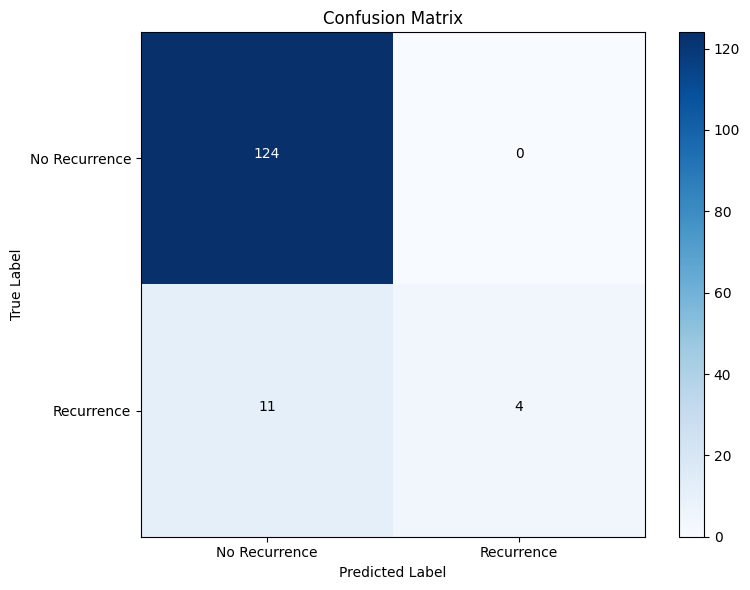

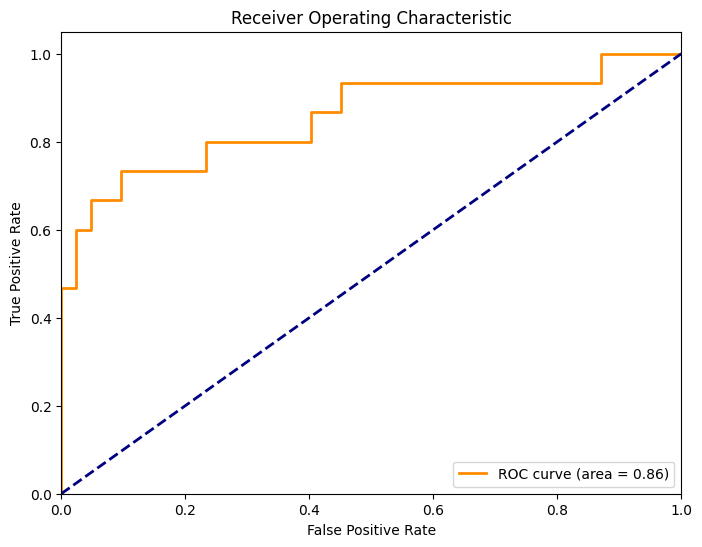

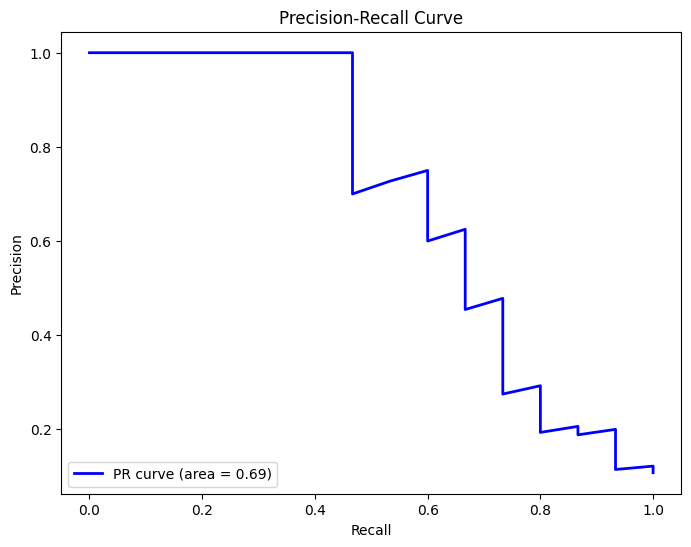

Final model performance:
Accuracy: 0.9209
AUC: 0.8567
F1 Score: 0.8996


In [79]:
# Example usage:

# Build the advanced RNN model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (time_steps, features)
advanced_model = build_advanced_rnn_model(
    input_shape=input_shape,
    rnn_type='LSTM',       # 'LSTM' or 'GRU'
    units=128,             # Number of RNN units
    bidirectional=True,    # Use bidirectional RNN
    attention=False,       # Attention mechanism not needed for this data
    dropout_rate=0.3,      # Dropout rate for regularization
    l1_reg=0.0001,         # L1 regularization strength
    l2_reg=0.0001          # L2 regularization strength
)

# Train the model with advanced callbacks
history = train_with_advanced_callbacks(
    model=advanced_model,
    X_train=X_train_seq,
    y_train=y_train,
    X_val=X_val_seq,
    y_val=y_val,
    batch_size=32,
    epochs=100,
    early_stopping_patience=10,
    reduce_lr_patience=5
)

# Evaluate the model
metrics = evaluate_binary_classifier(
    model=advanced_model,
    X_test=X_test_seq,
    y_test=y_test
)

print(f"Final model performance:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"AUC: {metrics['auc']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")